

# 사전 정보

## scRNA seq과 10xGenomics

scRNA-seq는 single-cell RNA sequencing의 줄임말로, 하나의 세포에서 mRNA를 측정하는 방법입니다. 이 기술은 기존 bulk RNA-seq 방법과는 달리 하나의 세포에서 RNA를 추출하여 분석합니다. 이를 통해, 개별 세포의 유전자 발현 패턴, 전사체 감지, 변형과 발현의 상호작용 등을 이해할 수 있습니다.

`10xGenomics`는 scRNA-seq 분석에서 매우 인기있는 플랫폼으로 droplet-based 방법을 사용합니다. droplet-based 방법은 cell barcoding 및 unique molecular identifier(UMI)를 사용하여 RNA-seq 라이브러리를 생성하는 공정으로 사실상 현재 scRNA seq분야에 표준으로 사용됩니다.

# 사전 작업

`10xGenomics` 기술을 사용해 scRNA-seq을 진행하면 결과로 `fastq` 파일을 얻게 됩니다. `fastq` 파일을 `Seurat` 패키지에 바로 사용할 수는 없고, 10xGenomics에서 제공하는 [Cell Ranger](https://support.10xgenomics.com/single-cell-gene-expression/software/pipelines/latest/what-is-cell-ranger)를 사용해 맵핑을 진행해야 합니다. 

## 시퀀싱 데이터 준비

실험을 통해 다음과 같은 `fastq` 파일을 가지고 있다고 간주합니다. 여기에서는 학습 목적으로 아주 작은 데이터셋으로 진행합니다만 실제 데이터는 훨씬 큽니다. 

```bash
.(pbmc_1k_v3_fastqs)
├── pbmc_1k_v3_S1_L001_I1_001.fastq.gz
├── pbmc_1k_v3_S1_L001_R1_001.fastq.gz
├── pbmc_1k_v3_S1_L001_R2_001.fastq.gz
├── pbmc_1k_v3_S1_L002_I1_001.fastq.gz
├── pbmc_1k_v3_S1_L002_R1_001.fastq.gz
└── pbmc_1k_v3_S1_L002_R2_001.fastq.gz

```

## cell ranger 설치

여기에서는 설치 방법은 생략하고 공식 홈페이지 [링크](https://support.10xgenomics.com/single-cell-gene-expression/software/pipelines/latest/installation)를 참조하시기 바랍니다.


## cell ranger 실행


```bash
cellranger count --id=run_count_1kpbmcs \
   --fastqs=./pbmc_1k_v3_fastqs \
   --sample=pbmc_1k_v3 \
   --transcriptome=./refdata-gex-GRCh38-2020-A
   --nosecondary
```

위의 명령어를 통해 cell ranger를 실행할 수 있습니다. `--id` 는 생성되는 결과의 폴더명이며, `--fastqs`는 fastq 파일이 있는 폴더의 위치, `--sample`은 metadata에 들어가는 샘플 정보, `--transcriptome`는 참조 전사체의 위치 입니다.

저의 경우는 10x Genomics 사이트에서 다음의 명령어로 다운로드 받았습니다. 참고로 참조 전사체는 실험에 사용된 시료에 따라 다르게 사용해야 합니다.

```bash
wget https://cf.10xgenomics.com/supp/cell-exp/refdata-gex-GRCh38-2020-A.tar.gz
tar -zxvf refdata-gex-GRCh38-2020-A.tar.gz
```

## cell ranger 결과

cell ranger가 문제없이 작동했다면 `out` 폴더에 다음과 같은 파일과 폴더가 생겨납니다.

```bash
.(out)
├── analysis
├── cloupe.cloupe
├── filtered_feature_bc_matrix
├── filtered_feature_bc_matrix.h5
├── metrics_summary.csv
├── molecule_info.h5
├── possorted_genome_bam.bam
├── possorted_genome_bam.bam.bai
├── raw_feature_bc_matrix
├── raw_feature_bc_matrix.h5
└── web_summary.html
```

이중에 `Seurat` 패키지가 필요로 하는 것은 `filtered_feature_bc_matrix` 폴더 입니다. 폴더안에는 다음과 같은 파일이 들어있습니다.

```bash
.(filtered_feature_bc_matrix)
├── barcodes.tsv.gz
├── features.tsv.gz
└── matrix.mtx.gz

```

이걸로 모든 사전 준비가 완료되었습니다.

## 사용할 패키기 불러오기

### Seurat

`Seurat`은 R 프로그래밍 언어로 작성된 scRNA-seq 데이터 분석을 위한 유명한 패키지 중 하나입니다. Seurat은 높은 차원의 scRNA-seq 데이터에서 유전자 발현 패턴을 탐색하고 이를 이용하여 세포 및 클러스터의 식별과 분석, 특성 제시, 시각화 등 다양한 분석 작업을 수행할 수 있습니다. Seurat은 다양한 데이터 전처리 및 정규화 기능과 함께 차원 축소, 클러스터링, 시각화, 서브셋 생성, 유전자 발현 분석, 세포간 상호작용 분석 등 다양한 분석 도구를 제공합니다. Seurat은 현재까지 업데이트와 기능 추가가 활발하게 이루어지고 있으며, scRNA-seq 분석에 필수적인 유틸리티 패키지 중 하나입니다.

### scDblFinder
`scDblFinder`는 단일 세포 RNA 시퀀싱 데이터에서 더블렛(두 개의 세포가 동시에 캡처되어 하나의 세포로 보이는 것) 현상을 탐지하고 제거하기 위한 R 패키지입니다. 이 패키지는 UMI(Unique Molecular Identifier)를 기반으로하여 두 개 이상의 세포에서 동시에 탐지된 UMIs를 찾아서 더블렛으로 추정하고, 더블렛으로 추정된 셀을 제거합니다. 이를 통해 scRNA-seq 데이터의 정확도와 해석력을 높일 수 있습니다. 또한, scDblFinder는 Seurat 및 SingleCellExperiment 형식의 데이터를 지원하며, 다양한 분석 옵션을 제공하여 사용자가 데이터에 맞게 조정할 수 있습니다.

### tidyverse

`tidyverse`는 데이터 분석에 필요한 필수 R 패키지들의 모음으로 데이터 처리, 시각화, 모델링, 프로그래밍 등의 다양한 작업을 수행하는 데 사용됩니다. 주요 패키지로는 ggplot2, dplyr, tidyr, readr, purrr, tibble, stringr, forcats 등이 있습니다.


In [2]:
options(verbose=FALSE) # Seurat 함수들이 실행될 때 로그 메시지를 표시하지 않습니다.
options(tidyverse.quiet=TRUE) # tidyverse 패키지의 로그 메시지가 출력되지 않습니다.
options(warn=-1)
options(future.rng.onMisuse="ignore")

library(Seurat)
library(tidyverse)
library(scDblFinder)
library(future) # Enable parallelization
plan("multicore", workers=30) # cpu core에 맞게 조절합니다.
# plan()

### 패키지 버전 확인

#### 사용한 Seurat 패키지의 버전

In [3]:
packageVersion("Seurat")

[1] ‘4.3.0’

#### 사용한 scDblFinder 패키지의 버전

In [4]:
packageVersion("scDblFinder")

[1] ‘1.12.0’

# Ambient RNA 제거하기

`Cellranger`에서 얻은 `raw_feature_bc_matrix.h5` 파일에 [CellBender](https://cellbender.readthedocs.io/en/latest/)로 ambient RNA 데이터들을 제거해 줍니다.

```bash
cellbender remove-background \
                 --cuda \
                 --input raw_feature_bc_matrix.h5 \
                 --output cellbender_output.h5
```

# Seurat 개체 만들기

먼저 데이터를 읽어오는 것으로 시작합니다. `Read10X()` 함수를 사용하면 간단하게 UMI count 행렬을 불러 올수 있습니다. UMI count 행렬은 앞서 `cell ranger`를 통해 만들어 진 것으로 scRNA-seq 실험에서 얻어진 유전자 발현 데이터를 행렬 형태로 나타낸 것으로, 행은 각각의 세포를 나타내고, 열은 유전자를 나타냅니다.

그런 다음 `CreateSeuratObject()`함수를 사용해 Seurat 개체를 생성합니다. 그러면 UMI count 행렬은 `seurat_obj[["RNA"]]@counts`에 저장되게 됩니다. 

In [5]:
# count 행렬 데이터 불러오기
seurat_obj <- Read10X_h5(data.dir="../input/cellbender_output.h5")
# 원시(정규화되지 않은 데이터)로 Seurat 객체를 초기화합니다.
seurat_obj <- CreateSeuratObject(counts=seurat_obj, project="pbmc1k", min.cells=3, min.features=200)
seurat_obj

An object of class Seurat 
20206 features across 1198 samples within 1 assay 
Active assay: RNA (20206 features, 0 variable features)

## count 행렬은 어떻게 생겼을까?

In [6]:
# 처음 5개의 세포에 있는 몇 가지 유전자를 확인해봅니다.
seurat_obj[["RNA"]]@counts[c("CD3D", "TCL1A", "MS4A1"), 1:3]

3 x 3 sparse Matrix of class "dgCMatrix"
      AAACCCAAGGAGAGTA-1 AAACGCTTCAGCCCAG-1 AAAGAACAGACGACTG-1
CD3D                   .                  .                  6
TCL1A                  .                  9                  .
MS4A1                  .                  5                  .

## Seurat 개체의 메타데이터는 어디에 저장될까?

`seurat_obj@meta.data` 혹은 `seurat_obj[[]]`을 통해 메타데이터를 확인할 수 있습니다.

In [7]:
head(seurat_obj@meta.data, 5)

,orig.ident,nCount_RNA,nFeature_RNA
,<fct>,<dbl>,<int>
AAACCCAAGGAGAGTA-1,pbmc1k,12861,3871
AAACGCTTCAGCCCAG-1,pbmc1k,9432,3234
AAAGAACAGACGACTG-1,pbmc1k,6520,2631
AAAGAACCAATGGCAG-1,pbmc1k,4362,2121
AAAGAACGTCTGCAAT-1,pbmc1k,9905,3157


# Pre-processing

## 서열 데이터 품질 관리

scRNA seq 데이터의 분석의 신뢰성을 얻기 위해서 데이터의 품질 관리는 필수이빈다. `Seurat`을 사용하면 품질관리(QC) 지표를 쉽게 탐색하고 사용자 정의 기준에 따라 세포를 필터링할 수 있습니다. 일반적으로 사용되는 QC 기준은 다음 세가지 입니다.

- 각 세포에서 검출된 고유 유전자의 수.
    - 품질이 낮은 세포는 종종 유전자가 매우 적습니다.
    - 이중 또는 다중의 세포가 들어간 droplet에는 비정상적으로 유전자 수가 높습니다.
- 각 세포에서 검출된 총 서열의 수(고유 유전자의 수와 밀접한 상관관계가 있음)
- 미토콘드리아 게놈에 매핑되는 서열의 비율
    - 품질이 낮거나 죽어가는 세포에는 미토콘드리아 유전자가 많이 발견됩니다.

    
### QC 지표 시각화하기

#### 바이올린 플랏

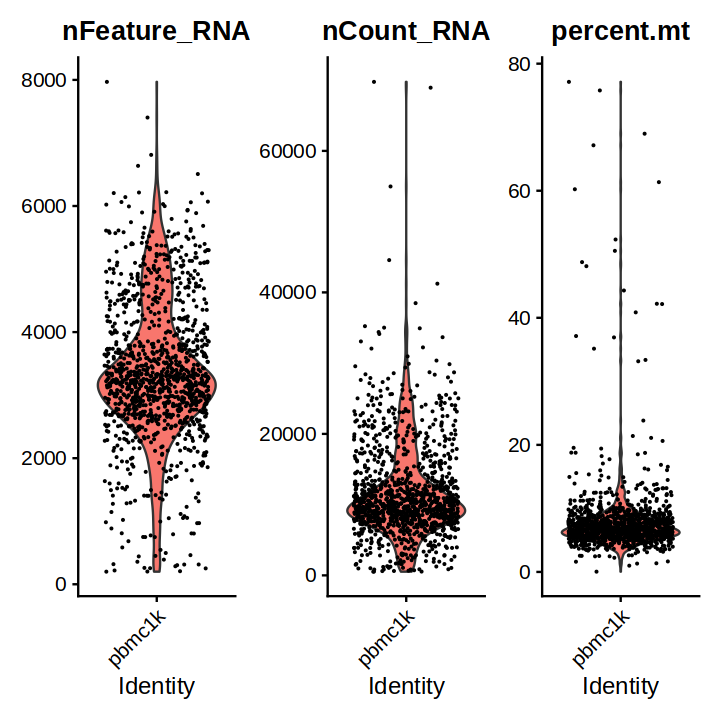

In [8]:
seurat_obj[["percent.mt"]] <- PercentageFeatureSet(seurat_obj, pattern="^MT-") 
# mouse 시료의 경우 pattern을 "^mt-"로 변경해야 합니다.

plot <- VlnPlot(seurat_obj, features=c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol=3)

options(repr.plot.width=6, repr.plot.height=6)
plot

#### Scatter 플랏

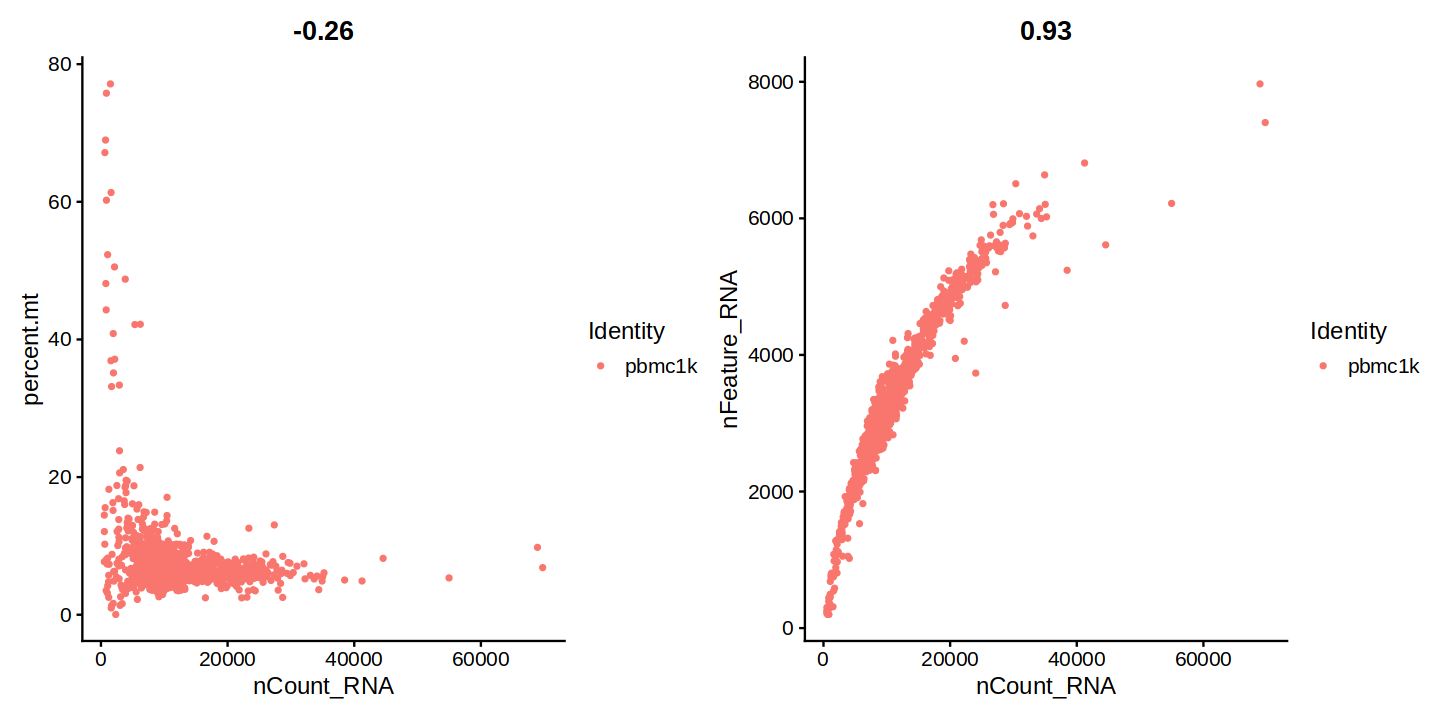

In [9]:
plot1 <- FeatureScatter(seurat_obj, feature1="nCount_RNA", feature2="percent.mt")
plot2 <- FeatureScatter(seurat_obj, feature1="nCount_RNA", feature2="nFeature_RNA")

options(repr.plot.width=12, repr.plot.height=6)
plot1 + plot2

### QC 및 추가 분석을 위한 세포 선택하기

위의 결과를 토대로 `nFeature_RNA`가 200개에서 6000개 사이이고 `percent.mt`가 20 이하인 세포들만 선택합니다.


In [10]:
seurat_obj <- subset(seurat_obj, subset=nFeature_RNA > 200 & nFeature_RNA < 6000 & percent.mt < 20)

아직 모든 QC 과정이 끝난 것은 아닙니다. `PCA`를 진행하고나서 `scDblFinder` 패키지를 사용해 추가적인 더블렛 데이터를 제거하겠습니다.

## 데이터 정규화하기

QC를 통해 일부 데이터를 제거한 다음 단계는 데이터를 정규화하는 것입니다. 여기서는 각 세포의 발현 값을 전체 발현으로 나누고 스케일 계수(기본적으로 10,000)를 곱한 다음 로그 변환하는 `LogNormalize`방법을 사용합니다. 이렇게 정규화된 값은 `seurat_obj[["RNA"]]@data`에 저장됩니다.

In [11]:
seurat_obj <- NormalizeData(seurat_obj, verbose=FALSE)
seurat_obj <- FindVariableFeatures(seurat_obj, verbose=FALSE)
seurat_obj <- ScaleData(seurat_obj, verbose=FALSE)
seurat_obj <- RunPCA(seurat_obj, verbose=FALSE)

### Elbow 플랏 그리기

`Seurat`에서 clustering을 수행하기 전에는 몇 개의 차원(dimension)을 사용할지 결정해야 합니다. 차원의 수는 PCA와 같은 차원 축소 기법을 사용하여 줄여진 차원의 수를 의미합니다. 그리고 이 차원의 수는 클러스터링 알고리즘에 사용됩니다.

그러나 차원의 수가 너무 적거나 많으면 적절한 클러스터링이 어려울 수 있습니다. 차원이 적을 경우 정보 손실이 크게 발생하고, 차원이 많을 경우에는 불필요한 차원의 포함으로 인해 과적합(overfitting)이 발생할 가능성이 있습니다.

따라서 적절한 차원의 수를 선택하기 위해 elbow plot을 사용합니다. elbow plot은 차원의 수를 x축으로, 해당 차원의 데이터를 잘 설명하는 정도(예: variance)를 y축으로 나타냅니다. 이 때, 차원의 수를 늘리면 y축 값은 점점 증가하게 됩니다. 그러나 어느 지점 이후로는 y값이 더 이상 크게 증가하지 않고 평평해지는 지점이 나타나는데, 이 지점이 elbow point입니다. 이 지점 이후로는 차원을 늘려도 데이터를 잘 설명하지 못하므로, elbow point를 기준으로 적절한 차원의 수를 선택합니다. 이를 통해 데이터의 차원을 축소할 때, 적절한 차원의 수를 선택하여 과적합을 방지하고 필요한 정보만을 추출할 수 있습니다.

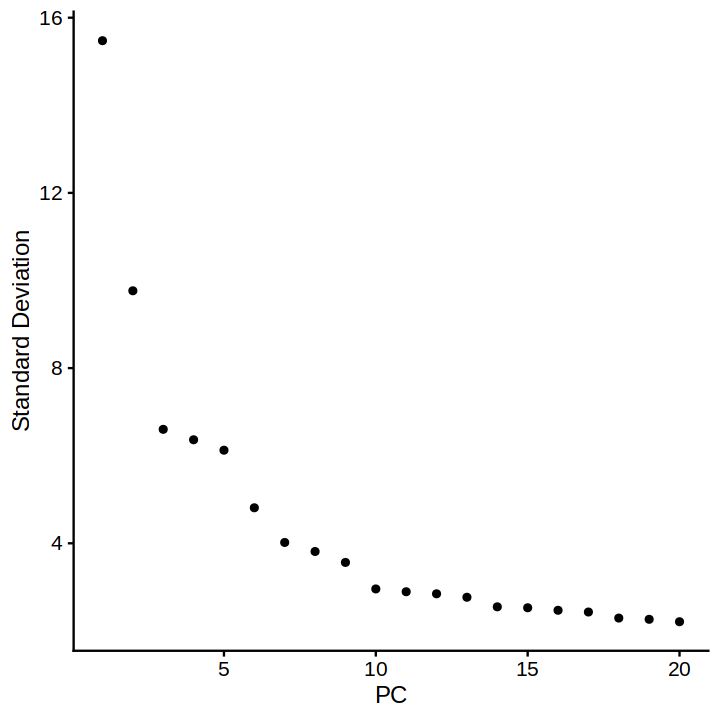

In [12]:
plot <- ElbowPlot(seurat_obj)

options(repr.plot.width = 6, repr.plot.height = 6)
plot

# Clustering

elbow 플랏에서 elbow point가 대략적으로 10임을 알 수 있습니다. 따라서 clustering의 `dims` 변수를 `1:10` 으로 지정합니다. 그런다음 UMAP을 그려보겠습니다.

## UMAP 그리기

UMAP은 Uniform Manifold Approximation and Projection의 약자로, scRNA-seq 데이터를 시각화하기 위한 비선형 차원 축소 방법 중 하나입니다. t-SNE와 유사한 기능을 가지고 있지만, 대규모 데이터셋에서 더욱 빠르고 정확한 임베딩을 제공합니다.

UMAP은 데이터의 국부적인 구조를 보존하는데 초점을 둡니다. 즉, 비슷한 특성을 가진 데이터들이 서로 가깝게 묶이고, 서로 다른 특성을 가진 데이터들은 더 멀리 배치되도록 임베딩을 생성합니다. 이를 통해, scRNA-seq 데이터의 복잡한 구조를 파악하고 시각화할 수 있습니다.



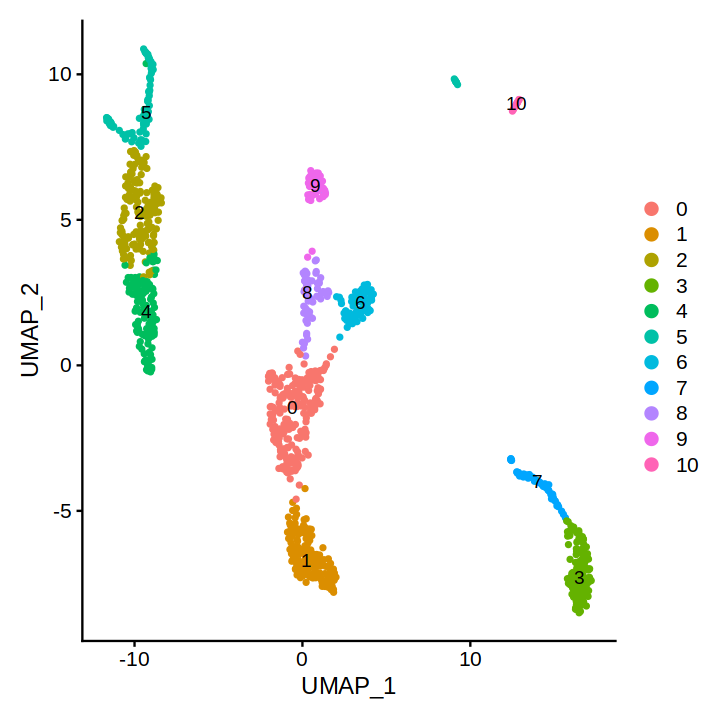

In [13]:
seurat_obj <- FindNeighbors(seurat_obj, dims = 1:10, verbose = FALSE)
seurat_obj <- FindClusters(seurat_obj, resolution = 0.5, verbose = FALSE)
# 일반적으로 resolution 값은 0.1 ~ 1.0 사이의 값을 많이 사용합니다. 
# 값이 작을수록 세분화된 군집을 얻을 수 있기 때문에
# 세포의 종류나 상태 등을 더 세부적으로 파악하고자 할 때는 작은 값이 유용합니다. 
# 반면 큰 값은 대부분의 데이터를 하나의 군집으로 묶어줌으로써 전체적인 데이터 구조를 파악하는 데에 유용할 수 있습니다.
seurat_obj <- RunUMAP(seurat_obj, dims = 1:10, verbose = FALSE)

plot <- DimPlot(seurat_obj, reduction = "umap", label=TRUE)

options(repr.plot.width = 6, repr.plot.height = 6)
plot

위의 UMAP 플랏을 통해 총 10개의 cluster로 나누어 졌음을 알 수 있습니다. 이제 추가적인 QC를 진행해보겠습니다.

## scDblFinder를 사용해 doublet 제거 하기

`scDblFinder`는 클러스터 정보를 기반으로 인공적으로 생성된 더블렛을 찾아냅니다. 아래 코드를 통해 더블렛을 찾고 UMAP 플랏에 표시해보겠습니다.

Assuming the input to be a matrix of counts or expected counts.

11 clusters

Creating ~5000 artificial doublets...

as(<dgeMatrix>, "dgCMatrix") is deprecated since Matrix 1.5-0; do as(., "CsparseMatrix") instead

Dimensional reduction

Evaluating kNN...

Training model...

iter=0, 32 cells excluded from training.

iter=1, 29 cells excluded from training.

iter=2, 30 cells excluded from training.

Threshold found:0.519

30 (2.6%) doublets called



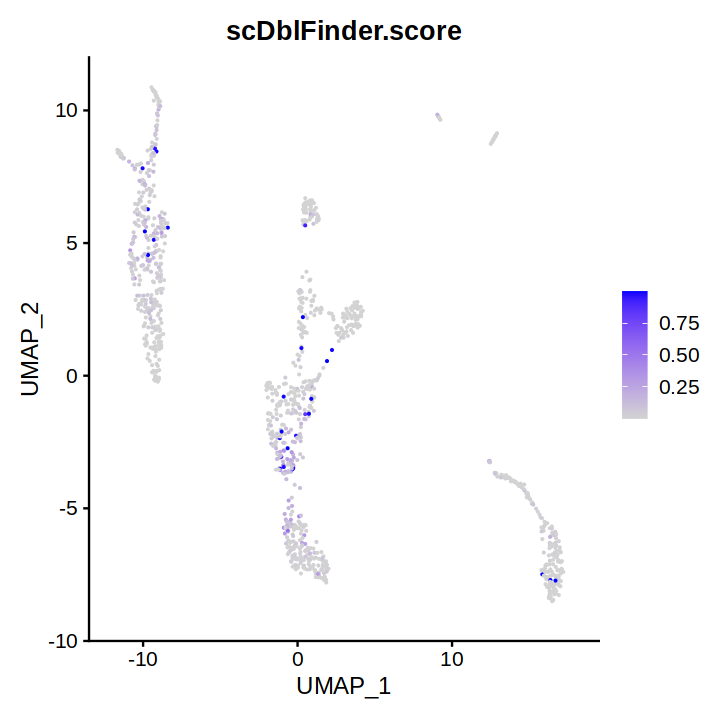

In [14]:
sce <- scDblFinder(GetAssayData(seurat_obj, slot = "counts"), clusters = Idents(seurat_obj))
# scDblFinder 결과 점수를 다시 Seurat 객체로 옮깁니다.
seurat_obj$scDblFinder.score <- sce$scDblFinder.score

p <- FeaturePlot(seurat_obj, "scDblFinder.score", pt.size = 0.1) 
options(repr.plot.width = 6, repr.plot.height = 6)
p

`scDblFinder` 결과에서 Threshold 값이 `0.519` 라는 것과 총 30(2.6%)개의 더블렛이 계산되었습니다. 다시 `subset()`함수를 사용해 scDblFinder 값이 0.519 이하인 세포만 고르는 QC 과정을 진행하겠습니다.

### 더블렛 제거하기

In [15]:
# 개체 메타 데이터의 값에 대한 하위 집합만들기
seurat_obj <- subset(x = seurat_obj, subset = scDblFinder.score < 0.519 )

DefaultAssay(seurat_obj) <- "RNA"  # default assay is RNA
seurat_obj <- NormalizeData(seurat_obj, verbose = FALSE)
seurat_obj <- FindVariableFeatures(seurat_obj, verbose = FALSE)
seurat_obj <- ScaleData(seurat_obj, verbose = FALSE)
seurat_obj <- RunPCA(seurat_obj, verbose = FALSE)
seurat_obj <- FindNeighbors(seurat_obj, dims = 1:10, verbose = FALSE)
seurat_obj <- FindClusters(seurat_obj, resolution = 0.5, verbose = FALSE)
seurat_obj <- RunUMAP(seurat_obj, dims = 1:10, verbose = FALSE)

p <- DimPlot(seurat_obj, label = TRUE)

options(repr.plot.width = 7, repr.plot.height = 7)
p

# Cell type identification

각각의 클러스터들이 어떤 세포인지 알아내는 작업을 합니다.`Seurat`의 `FindAllMarkers()`함수를 사용하면 나머지 모든 세포와 비교해 클러스터에 대한 유전자 마커를 찾을 수 있습니다.

## Marker gene 찾기

In [17]:
markers <- FindAllMarkers(seurat_obj, only.pos = TRUE, verbose = FALSE)
write_csv(markers, "../output/pbmc1k_marker.csv") # 결과를 csv 파일로 저장
markers %>% head()

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
S100A12,4.929494e-211,3.984628,0.979,0.047,9.960536e-207,0,S100A12
VCAN,3.023544e-202,4.236786,1.000,0.086,6.109374e-198,0,VCAN
CD14,3.015410e-195,2.387003,0.954,0.058,6.092936e-191,0,CD14
CSF3R,2.588854e-192,2.561836,0.979,0.080,5.231038e-188,0,CSF3R
MNDA,1.513641e-189,3.044325,0.993,0.104,3.058462e-185,0,MNDA
S100A8,1.971209e-188,5.905527,0.996,0.142,3.983026e-184,0,S100A8


`FindAllMarkers()` 결과는 데이터프레임입니다. `avg_log2FC`는 다른 클러스터와 비교해 발현량이 얼마나 차이나는지를 의미합니다. 해당 열을 가지고 각 클러스터당 상위 5개의 유전자 마커를 추려서 heatmap 을 그려봅니다.

## Marker gene heatmap

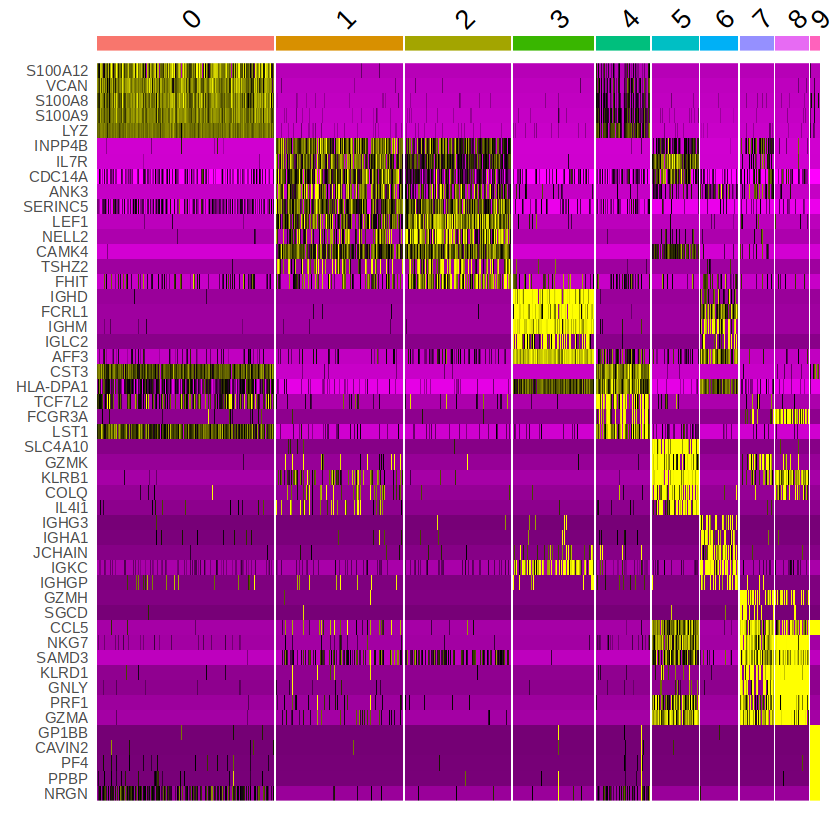

In [18]:
top5 <- markers %>% group_by(cluster) %>% top_n(n = 5, wt = avg_log2FC)
p <- DoHeatmap(seurat_obj, features = top5$gene) + NoLegend()

options(repr.plot.width = 7, repr.plot.height = 7)
p

위의 heatmap은 멋져보이기는 하지만 그렇게 큰 정보를 제공해주지는 않습니다. 일반적으로 클러스터가 어떤 세포인지 알아내는 작업이 scRNA seq 분석방법에서 가장 중요한 부분이며 여러가지 접근법이 있지만 가장 덜 자동화된 부분이기도 합니다.

가장 일반적인 방법은 `FindAllMarkers()` 함수를 이용해 얻은 각 클러스터의 유전자 마커와 참조 데이터 세트를 비교 하는 것입니다. 참조 데이터 세트란, 이미 잘 정의된 세포 유형들의 scRNA-seq 데이터로 현재 분석 중인 데이터의 클러스터들을 참조 데이터 세트와 비교하여 유사한 패턴을 가진 세포 유형을 찾아내는 것입니다. 이 작업은 시간이 아주 많이 필요하며 작업자에 따라 다른 결과가 나옵니다. 그래서 이번에는 `ChatGPT`를 사용하는 방법으로 해보겠습니다.

## `ChatGPT` 사용하기

> `ChatGPT`에 대한 자세한 설명은 생략합니다. 

프롬프터에 클러스터의 유전자 마커를 쉽게 입력하기 위해 다음의 코드를 사용합니다.

In [19]:
# 빈 리스트 생성
marker_list <- list()
gene_number <- 10 # 10개의 유전자만 찾아낼때

# for loop으로 리스트에 값 추가
for (i in unique(Idents(seurat_obj))) {
  marker_list[[paste0("cluster",i)]] <- markers %>% group_by(cluster) %>% top_n(gene_number, avg_log2FC) %>%
      ungroup() %>% arrange(cluster, desc(avg_log2FC)) %>% filter(cluster == i) %>% .$gene
}

# 결과 출력
marker_list

$cluster0
 [1] "S100A8"  "S100A9"  "LYZ"     "VCAN"    "S100A12" "FCN1"    "MNDA"   
 [8] "CTSS"    "NAMPT"   "PLXDC2" 

$cluster3
 [1] "IGHM"      "AFF3"      "IGHD"      "IGLC2"     "FCRL1"     "BANK1"    
 [7] "TCL1A"     "BACH2"     "CD79A"     "LINC00926"

$cluster7
 [1] "GZMH"  "NKG7"  "CCL5"  "SGCD"  "SAMD3" "CST7"  "GZMK"  "TOX"   "GZMA" 
[10] "KLRG1"

$cluster1
 [1] "INPP4B"  "IL7R"    "ANK3"    "CDC14A"  "SERINC5" "BCL11B"  "IL32"   
 [8] "RORA"    "CAMK4"   "TTC39C" 

$cluster6
 [1] "IGKC"    "IGHA1"   "JCHAIN"  "IGHG3"   "IGHGP"   "IGHG1"   "IGHG2"  
 [8] "BANK1"   "OSBPL10" "MS4A1"  

$cluster2
 [1] "LEF1"    "NELL2"   "TSHZ2"   "FHIT"    "CAMK4"   "PRKCA"   "BCL11B" 
 [8] "PDE3B"   "TXK"     "TRABD2A"

$cluster5
 [1] "KLRB1"      "SLC4A10"    "IL4I1"      "GZMK"       "COLQ"      
 [6] "ZBTB16"     "ADAM12"     "IL32"       "AL136456.1" "AGAP1"     

$cluster4
 [1] "TCF7L2"   "CST3"     "HLA-DPA1" "FCGR3A"   "LST1"     "HLA-DPB1"
 [7] "AIF1"     "HLA-DRB1" "HLA-DRA"  "IFI30"   

$cluster8
 [1] "GNLY"   "NKG7"   "PRF1"   "KLRD1"  "GZMA"   "KLRF1"  "SPON2"  "FGFBP2"
 [9] "CST7"   "GZMB"  

$cluster9
 [1] "PPBP"      "GP1BB"     "NRGN"      "PF4"       "CAVIN2"    "TUBB1"    
 [7] "CLU"       "GNG11"     "RGS18"     "HIST1H2AC"

위 코드의 출력을 가지고 `ChatGPT`에 입력했더니 다음과 같이 말했습니다.

```
주어진 유전자 목록만으로는 각각의 클러스터의 정확한 세포 유형을 알 수 없습니다. 유전자는 여러 종류의 세포에서 발현될 수 있기 때문입니다. 유전자의 발현 패턴을 분석하거나 추가적인 실험 결과와 함께 고려해야만 각 클러스터의 세포 유형을 추론할 수 있습니다.

그러나 일반적으로 각 클러스터에 대한 예상 세포 유형은 다음과 같습니다:

$cluster0: 이 클러스터는 PBMC에서 neutrophils을 나타내는 것으로 추정됩니다.
$cluster1: 이 클러스터는 PBMC에서 CD4 T cells을 나타내는 것으로 추정됩니다.
$cluster2: 이 클러스터는 PBMC에서 B cells을 나타내는 것으로 추정됩니다.
$cluster3: 이 클러스터는 PBMC에서 B cells을 나타내는 것으로 추정됩니다.
$cluster4: 이 클러스터는 PBMC에서 monocytes을 나타내는 것으로 추정됩니다.
$cluster5: 이 클러스터는 PBMC에서 NK cells을 나타내는 것으로 추정됩니다.
$cluster6: 이 클러스터는 PBMC에서 B cells을 나타내는 것으로 추정됩니다.
$cluster7: 이 클러스터는 PBMC에서 CD8 T cells을 나타내는 것으로 추정됩니다.
$cluster8: 이 클러스터는 PBMC에서 NK cells을 나타내는 것으로 추정됩니다.
$cluster9: 이 클러스터는 PBMC에서 platelets을 나타내는 것으로 추정됩니다.
```

위의 결과를 통해 대부분의 클러스터 타입을 알 수 있지만, B cell이 3개 NK cell이 2개로 중복됩니다. 좀 더 세분화하기 위해 B cell의 유전자 마커를 물어봅니다.

```
B cell은 다양한 sub type으로 분류될 수 있습니다. 일부 sub type들과 그에 따른 대표 마커들은 다음과 같습니다.

- Naive B cell
    CD19, CD20, CD27-, IgD+, IgM+
- Memory B cell
    CD19, CD20, CD27+, IgD-, IgM+/-
- Plasma cell
    CD19, CD20-, CD38++, CD138+, MUM1+, IRF4+, XBP1+
- Germinal center B cell
    CD19, CD20, CD77+, CD10+, BCL6+, AID+
- Regulatory B cell (Breg)
    CD19, CD20, CD24++, CD38++, CD25+, IL-10+
- B1 B cell
    CD19, CD20, CD27+, IgM+, CD43+
- Marginal zone B cell
    CD19, CD20, CD27-, CD43-, IgM+, IgD+, CD23-, CD21+

각 sub type마다 대표적인 마커들이 있지만, 이것들만으로 모든 sub type을 완벽하게 분류하는 것은 어렵습니다. 따라서, sub type 분류는 보통 여러 마커를 조합하여 결정됩니다.
```

이번에는 NK cell 세분화를 위한 유전자 마커를 물어봅니다.

```
NK 세포는 크게 두 가지 subset으로 나눌 수 있습니다: CD56bright NK 세포와 CD56dim NK 세포입니다. CD56bright NK 세포는 주로 면역 조절에 관여하며, cytokine을 분비하는 역할을 합니다. 반면 CD56dim NK 세포는 주로 세포 독성에 관여하며, 인체 내에서 암세포와 바이러스에 대한 첫 번째 방어선 역할을 합니다.

CD56bright NK 세포를 구별하는 유전자 마커로는 CD56(bright) (NCAM1)과 CD16 (FCGR3A)이 있습니다. 반면 CD56dim NK 세포를 구별하는 유전자 마커로는 CD56(dim) (NCAM1)과 KIR (Killer-cell immunoglobulin-like receptors)가 있습니다. KIR은 NK 세포의 분화 상태, 활성 상태, 대상 세포와의 상호 작용 등을 조절합니다.
```

위의 결과와 `pbmc1k_marker.csv` 파일을 비교하면서 다음과 같이 클러스터의 이름을 지정합니다.

> `ChatGPT`를 사용한 방법은 정확하지 않고 힌트정도만 알 수 있습니다. 실제 실험결과라면 `SingleR` 패키지 혹은 문헌 검색을 통해 직접 찾아보시기 바랍니다. 

그리고 UMAP 플랏을 그려서 결과를 확인합니다.

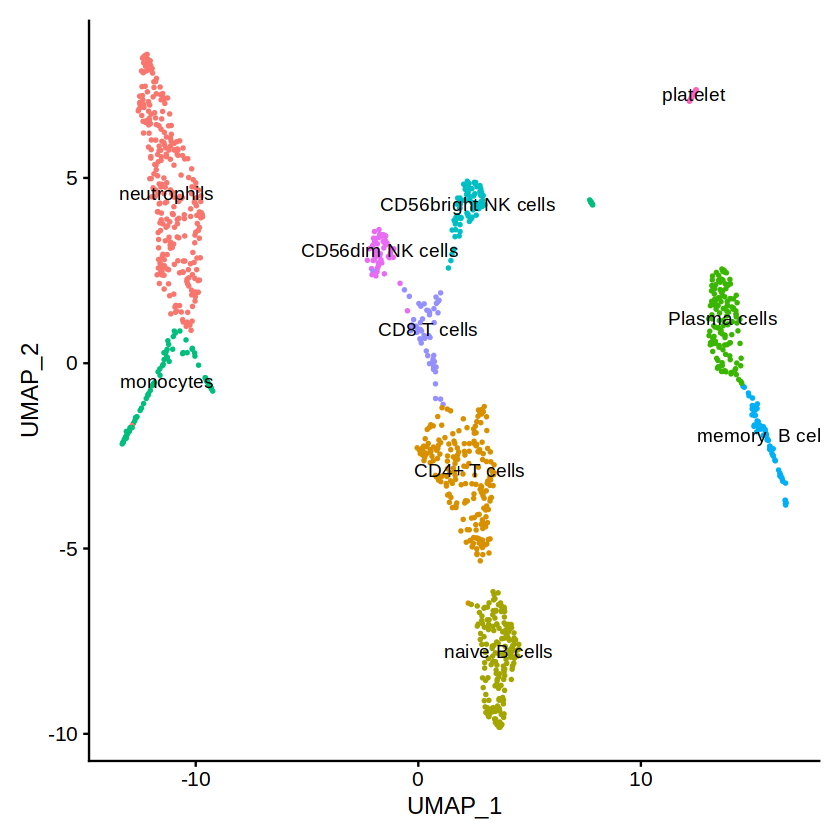

In [20]:
# 참조를 위해 이전 ID 클래스(클러스터 레이블)를 저장합니다.
seurat_obj[["old.ident"]] <- Idents(object = seurat_obj)

# 레이블 변경하기
seurat_obj <- RenameIdents(
    object = seurat_obj,
    `0` = "neutrophils",
    `1` = "CD4+ T cells",
    `2` = "naive B cells",
    `3` = "Plasma cells",
    `4` = "monocytes",
    `5` = "CD56bright NK cells",
    `6` = "memory  B cells",
    `7` = "CD8 T cells",
    `8` = "CD56dim NK cells",
    `9` = "platelet"
    )


p <- DimPlot(seurat_obj, reduction = "umap", label = TRUE, pt.size = 0.5) + NoLegend()

options(repr.plot.width = 7, repr.plot.height = 7)
p

# 마치며

클러스터에 포함된 세포 수를 확인해보고 `RDS` 파일을 저장하면서 마무리 하겠습니다.

## 클러스터당 세포 수 확인

In [21]:
table(Idents(seurat_obj))


        neutrophils        CD4+ T cells       naive B cells        Plasma cells 
                284                 204                 169                 130 
          monocytes CD56bright NK cells     memory  B cells         CD8 T cells 
                 87                  74                  60                  54 
   CD56dim NK cells            platelet 
                 53                  15 

## 클러스터당 세포 비율 확인

In [22]:
prop.table(table(Idents(seurat_obj)))


        neutrophils        CD4+ T cells       naive B cells        Plasma cells 
         0.25132743          0.18053097          0.14955752          0.11504425 
          monocytes CD56bright NK cells     memory  B cells         CD8 T cells 
         0.07699115          0.06548673          0.05309735          0.04778761 
   CD56dim NK cells            platelet 
         0.04690265          0.01327434 

## RDS 파일로 저장하기

RDS 파일을 저장해두면 추후 분석에 위의 과정을 반복할 필요가 없습니다.

In [23]:
saveRDS(seurat_obj, file = "../output/pbmc1k_final.rds")

지금 까지 살펴본 내용을 요약해보면 다음과 같습니다.

- Pre-processing: 데이터 전처리를 통해 불필요한 변수 제거, 정규화 등을 수행합니다.
- Dimensionality reduction: 차원 축소 기법을 사용해 데이터의 주요 구조를 파악합니다.
- Clustering: 유사한 특성을 가진 데이터들을 그룹화합니다.
- Cell type identification: 각 클러스터에 대해 유전자 발현 패턴 등을 비교하여 cell type을 추론합니다.

이후 진행되는 scRNA-seq Downstream analysis는 여기서 얻은 결과를 기반으로 합니다. 따라서 여기서의 결과가 부정확하거나 신뢰성이 떨어지면 추가 분석에서 얻은 결과 또한 의미가 없습니다. 그러므로 분석에서 사용된 데이터의 품질, 분석 방법의 적절성, 도구의 성능 등을 철저히 검토하고 확실한 기준에 따라 분석을 수행하세요. 또한, 추후에 데이터나 분석 방법이 변경되는 경우 이전의 결과와의 비교를 통해 신뢰성을 유지할 수 있도록 관리하는 것도 잊지 말아야 합니다.